# Prototyping intertidal exposure mapping workflow

- Import NIDEM
- Import OTPS
- For area of interest, calculate median time of exposure 
    between inundations from OTPS modelling for the period of data included into the NIDEM workflow
- Build values back into the NIDEM xarray
- Save as a raster



In [1]:
import datacube
from odc.ui import with_ui_cbk
import sys

sys.path.append("../Scripts")
from dea_plotting import display_map
# from otps import TimePoint
# from otps import predict_tide
# import otps
from dea_coastaltools import tidal_tag
from dea_coastaltools import tidal_stats

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
dc = datacube.Datacube(app="intertidal_exposure")

In [3]:

#set up our inputs to collect_training_data
products =  ['nidem']
time = ('1986', '2018')
# x = (x1, x2)
# y = (y1, y2)
x=(151.39537811278885, 151.96872711181226)
y=(-23.920677965781103, -24.241642828863014)

# lon	151.39537811278885
# lat	-23.920677965781103

# lon	151.96872711181226
# lat	-24.241642828863014


# reduce_func = None
# calc_indices = ['NDVI','MNDWI']
# drop = False
# zonal_stats = 'median'
# return_coords = True

# Set up the inputs for the ODC query
measurements =  ['nidem']
resolution = (-30,30)
output_crs='epsg:3577'

query = {
    'product': products,
    'x': x,
    'y': y
#     'time': time,
#     'measurements': measurements,
#     'resolution': resolution,
#     'output_crs': output_crs,
#     'group_by' : 'solar_day',
}

In [4]:
# Plot training data in an interactive map
display_map(x=x, y=y)

In [5]:
tp_x = 151.5934
tp_y = -24.0299

x1=(tp_x, tp_x)
y1=(tp_y, tp_y)

display_map(x=x1, y=y1)

In [6]:
ds = dc.load(product='nidem',
             x=x,
             y=y
             #              **query
#             x=(153.3, 153.4),
#             y=(-27.5, -27.6)
#             time=('1986','2018')
            )
print(ds)

<xarray.Dataset>
Dimensions:      (time: 1, x: 2501, y: 1775)
Coordinates:
  * time         (time) datetime64[ns] 2001-07-02
  * y            (y) float64 -2.73e+06 -2.73e+06 ... -2.774e+06 -2.774e+06
  * x            (x) float64 1.941e+06 1.941e+06 ... 2.003e+06 2.004e+06
    spatial_ref  int32 3577
Data variables:
    nidem        (time, y, x) float32 -9999.0 -9999.0 ... -9999.0 -9999.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


In [7]:
ds = ds.where(ds.nidem > ds.nidem.min())

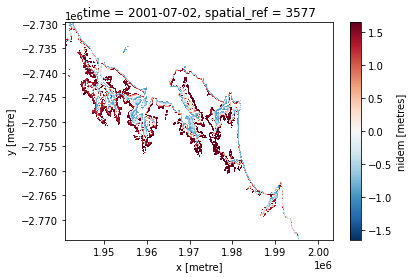

In [8]:
ds.nidem.plot()

In [9]:
# nidem_heights = ds.nidem.to_dataframe()

# nidem_heights_unique = nidem_heights.nidem.unique()
# len(nidem_heights_unique)

# OTPS

# Pulling tidal modelling for a given location code out of dea_coastaltools.py script

In [10]:
# Import required packages
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from otps import TimePoint
from otps import predict_tide
from datacube.utils.geometry import CRS

# Fix converters for tidal plot
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [11]:
def tidal_stats(
#                 ds, 
                start='1/1/1988',
                end='1/1/2019',
                tidepost_lat=None,
                tidepost_lon=None,
                plain_english=True, 
                plot=True,
                modelled_freq='10min',
                round_stats=3): 
    """
    Takes an xarray.Dataset and statistically compares the tides 
    modelled for each satellite observation against the full modelled 
    tidal range. This comparison can be used to evaluate whether the 
    tides observed by satellites (e.g. Landsat) are biased compared to 
    the natural tidal range (e.g. fail to observe either the highest or 
    lowest tides etc).    
       
    By default, the function models tides for the centroid of the 
    dataset, but a custom tidal modelling location can be specified 
    using `tidepost_lat` and `tidepost_lon`.
    
    Tides are modelled using the OTPS tidal modelling software based on
    the TPXO8 tidal model: http://volkov.oce.orst.edu/tides/tpxo8_atlas.html
    
    For more information about the tidal statistics computed by this 
    function, refer to Figure 8 in Bishop-Taylor et al. 2018:
    https://www.sciencedirect.com/science/article/pii/S0272771418308783#fig8
    
    Parameters
    ----------     
    ds : xarray.Dataset
        An xarray.Dataset object with x, y and time dimensions  
    tidepost_lat, tidepost_lon : float or int, optional
        Optional coordinates used to model tides. The default is None,
        which uses the centroid of the dataset as the tide modelling 
        location.
    plain_english : bool, optional
        An optional boolean indicating whether to print a plain english 
        version of the tidal statistics to the screen. Defaults to True.
    plot : bool, optional
        An optional boolean indicating whether to plot how satellite-
        observed tide heights compare against the full tidal range. 
        Defaults to True.
    modelled_freq : str, optional
        An optional string giving the frequency at which to model tides 
        when computing the full modelled tidal range. Defaults to '2h', 
        which computes a tide height for every two hours across the
        temporal extent of `ds`.        
    round_stats : int, optional
        The number of decimal places used to round the output statistics.
        Defaults to 3.
        
    Returns
    -------
    A pandas.Series object containing the following statistics:
    
        tidepost_lat: latitude used for modelling tide heights
        tidepost_lon: longitude used for modelling tide heights
        observed_min_m: minimum tide height observed by the satellite
        all_min_m: minimum tide height from full modelled tidal range
        observed_max_m: maximum tide height observed by the satellite
        all_max_m: maximum tide height from full modelled tidal range
        observed_range_m: tidal range observed by the satellite
        all_range_m: full modelled tidal range 
        spread_m: proportion of the full modelled tidal range observed 
                  by the satellite (see Bishop-Taylor et al. 2018)
        low_tide_offset: proportion of the lowest tides never observed
                  by the satellite (see Bishop-Taylor et al. 2018)
        high_tide_offset: proportion of the highest tides never observed
                  by the satellite (see Bishop-Taylor et al. 2018)
        observed_slope: slope of any relationship between observed tide 
                  heights and time
        all_slope: slope of any relationship between all modelled tide 
                  heights and time
        observed_pval: significance/p-value of any relationship between 
                  observed tide heights and time
        all_pval: significance/p-value of any relationship between 
                  all modelled tide heights and time
    
    """
    
#     # Model tides for each observation in the supplied xarray object
#     ds_tides, tidepost_lon, tidepost_lat = tidal_tag(ds,
#                                                      tidepost_lat=tidepost_lat,
#                                                      tidepost_lon=tidepost_lon,
#                                                      return_tideposts=True)

    # Generate range of times covering entire period of satellite record
    all_timerange = pd.date_range(start=start,
                                  end=end,
                                  freq=modelled_freq)
    all_datetimes = all_timerange.values.astype('M8[s]').astype('O').tolist()  

    # Use the tidal model to compute tide heights for each observation:  
    all_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) 
                      for dt in all_datetimes]
    all_predictedtides = predict_tide(all_timepoints)   
    all_tideheights = [predictedtide.tide_m for predictedtide 
                        in all_predictedtides]

    if plot:
        
        # Create plot and add all time and observed tide data
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(all_timerange, all_tideheights, alpha=0.4)

    return all_timerange, all_tideheights

In [12]:
# all_timerange, all_tideheights = tidal_stats(tidepost_lat = tp_y,
#                                              tidepost_lon = tp_x)

# ## Save modelled tides as dataframe
#     ## Firstly convert the dates to series
# all_timerange = all_timerange.to_series()
#     ## Save dates and tideheights to pd.DataFrame
# modelledtides = pd.DataFrame(data={'timerange': all_timerange,
#                    'tideheights': all_tideheights})
#     ## Save dataframe as pickle file to avoid re-running the model
#         ## (very timely processing at 1 min intervals for 30 years!)
# modelledtides.to_pickle("tidepost_"+str(tp_y) + '_'+ str(tp_x) + "_modelledtides_10min.pkl")

'''-----------------------------------------------------------'''
# ## Load previously modelled tides for given tidepost.
modelledtides = pd.read_pickle("tidepost_"+str(tp_y) + '_'+ str(tp_x) + "_modelledtides_10min.pkl") ## Optional: load 1min or 2min model

# Exposure mapping approach 1
## Timestep mapping
Approach after Choi et al., 2016 exposure mapping based on ITEM in QLD

Method:
- Tidal model run for aoi at 10 minute intervals for x period of time(Ensure it captures at least 1 full tidal cycle - at least a month or longer)
- Starting with an xarray (ds) for the aoi containing NIDEM:
    - add new ds variable for each modelled timestep, masking the modelled tideheight against NIDEM  (pixels below modelled tideheight were masked out)
    - run a pixel drill through modelled timesteps to determine how many observations are returned as dry as a percentage of all observations for that pixel (this is the exposure calculation)
    - map the exposure for the aoi as a percentage of total (modelled) time
    - threshold the exposure ranges against NIDEM height

To do: 
- Look for some validation data
- Try again in Moreton Bay
- Consider the spatial frequency to run the tidal model
- Consider the temporal frequency to run the tidal model (time series and modelling frequency e.g. 1 month with 10 minute intervals)
- Consider other approaches incl my original plan for calculating daily or event exposure (e.g. average 2 hours exposure between tides).
    - Requires modelling the tidal curve (tricky! But perhaps a linear calculation between adjacent modelled tideheights might work. Similarly, reducing the accuracy (decimal places) of the modelled results and NIDEM might also improve modelling outputs)
    - Calculating individual exposure periods over x period of time and determining median time of exposure between successive tides

In [13]:
## Working code!! When time-mapping complete, upscale this cell
for timestep in modelledtides[-60005:-60000].index:
    print(modelledtides['tideheights'][timestep], timestep)
    ## For each modelled time, calculate wet vs dry pixels in aoi usingmodelled tideheight against NIDEM
    exp = (ds.where(ds.nidem >= modelledtides['tideheights'][timestep])).nidem
    ds[str(modelledtides['timerange'][timestep])] = exp

0.07 2017-11-10 07:20:00
-0.022 2017-11-10 07:30:00
-0.113 2017-11-10 07:40:00
-0.203 2017-11-10 07:50:00
-0.291 2017-11-10 08:00:00


In [151]:
ds['nidem'] = nidem

import pandas as pd

In [13]:
## Build a list of DataArrays to concat

## Create lists to store the nidem/model masked arrays and their respective model datetimes
da_list = []
index_list = []

## Loop through the modelled data, mask nidem for tideheight at each modelled datetime
for timestep in modelledtides[-60005:-60000].index:
    exp = (ds.where(ds.nidem >= modelledtides['tideheights'][timestep])).nidem
    da_list.append(exp)
    index_list.append(timestep)

## Store modelled datetimes as a pandas index
index = pd.Index(index_list, name='datetime')
    
## Concatenate the arrays on the new dimension 'datetime'
exp_ds = xr.concat(da_list, index)

## View array
exp_ds

<xarray.DataArray 'nidem' (datetime: 5, time: 1, y: 1775, x: 2501)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
...
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 2001-07-02
  * y            (y) float64 -2.73e+06 -2.73e+06 ... -2.774e+06 -2.774e+06
  * x            (x) float64 1.941e+06 1.941e+06 ... 2.003e+06 2.004e+06
    spatial_ref  int32 3577
  * datetime     (datetime) datetime64[ns] 2017-11-10T07:20:00 ... 2017-11-10...
Attributes:
    units:         metres
    nodata:        -9999
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [14]:
expmap = (~xr.ufuncs.isnan(exp_ds))#.mean()
expmap

<xarray.DataArray 'nidem' (datetime: 5, time: 1, y: 1775, x: 2501)>
array([[[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]],


       [[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]],


       [[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
...
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]],


       [[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]],


       [[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]]])
Coordinates:
  * time         (time) datetime64[ns] 2001-07-02
  * y            (y) float64 -2.73e+06 -2.73e+06 ... -2.774e+06 -2.774e+06
  * x            (x) float64 1.941e+06 1.941e+06 ... 2.003e+06 2.004e+06
    spatial_ref  int32 3577
  * datetime     (datetime) datetime64[ns] 2017-11-10T07:20:00 ... 2017-11-10...

In [15]:
expmap_stacked = expmap.stack(pixel=['y','x'])
expmap_stacked

<xarray.DataArray 'nidem' (datetime: 5, time: 1, pixel: 4439275)>
array([[[False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False]]])
Coordinates:
  * time         (time) datetime64[ns] 2001-07-02
    spatial_ref  int32 3577
  * datetime     (datetime) datetime64[ns] 2017-11-10T07:20:00 ... 2017-11-10...
  * pixel        (pixel) MultiIndex
  - y            (pixel) float64 -2.73e+06 -2.73e+06 ... -2.774e+06 -2.774e+06
  - x            (pixel) float64 1.941e+06 1.941e+06 ... 2.003e+06 2.004e+06

In [16]:
pxpc = []
for x in range (0,len(expmap_stacked.pixel)):
#     print(expmap_stacked.isel(pixel=x).mean().values)
    pxpc.append(expmap_stacked.isel(pixel=x).mean().values)
    

In [18]:
pxpc = np.array(pxpc)
pxpc = pxpc.reshape(len(expmap.y), len(expmap.x))
pxpc = xr.DataArray(pxpc, dims=['y', 'x'])

In [38]:
pxpc.dims

('y', 'x')

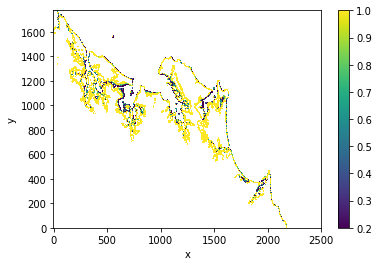

In [42]:
## Invert y-axis
pxpc = pxpc.reindex(y=pxpc.y[::-1])
pxpc = pxpc.where(pxpc > 0)
pxpc.plot()


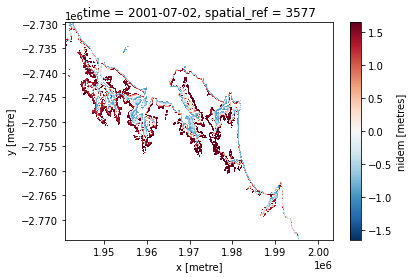

In [20]:
ds.nidem.plot()

In [184]:
# # pxpc2 = np.array(pxpc)
# # expmap_stacked.merge(pxpc2)
# pxpc2 = xr.DataArray(np.array(pxpc), dims='pixels')
# # expmap_stacked
# pxpc2

<xarray.DataArray (pixel: 10000)>
array([0., 0., 0., ..., 0., 0., 0.])
Dimensions without coordinates: pixel

In [ ]:
expmap_stacked
# expmap_stacked2 = xr.concat([expmap_stacked.isel(pixel=[0,10000]), pxpc2], 'pixels')

In [25]:
## Remove NIDEM for exposure calculation
nidem = ds['nidem']
ds = ds.drop_vars(names = 'nidem')

In [163]:
# # ds

# testvar = nidem.copy(deep=True)
# testvar = testvar.where(testvar == 'fake_value')
# testvar = testvar.rename('pc_px_exposed')
# testvar
# # pc_px_exposed = xr.DataArray(data=None, coords=[time, y , x], dims = ['time', 'y', 'x'])
# # ds['pc_px_exposed'] = pc_px_exposed

# # ds

In [164]:
# # pcpx_stacked = testvar.stack(pixel=['y','x'])
# ds

In [165]:
# ## Assign new values to pixel positions
# # pcpx_stacked.isel(time=0, pixel=0) = pcpx_stacked.isel(time=0, pixel=0).where(pcpx_stacked.isel(time=0, pixel=0) == 2)
# # pcpx_stacked.replace
# # pcpx_stacked.isel(time=0, pixel=0).assign({'pcpx_exposed': 2})
# pcpx_stacked

In [93]:
## Loop through each pixel pair by stacking to new 'pixel' variable. 
## Append percentage of exposed pixels to the dataframe (somehow)

ds_stacked = ds.stack(pixel=['y', 'x'])

# px_pc = []
# for x in range(0,len(stacked.pixel)): ## TEMPORARILY HASHED OUT WHILE TESTING
for x in range (0,5):
    arr = ds_stacked.isel(time=0, pixel=x).to_array()
    pc = np.sum(arr.values == int)/len(arr.values)
#     stacked.isel(time=0,pixel=x).assign({'pc_time_exposed':pc}) ## THIS LINE DIDN'T WORK AS INTENDED :(
#     px_pc.append(pc)

In [145]:
ds

<xarray.Dataset>
Dimensions:              (time: 1, x: 2501, y: 1775)
Coordinates:
  * time                 (time) datetime64[ns] 2001-07-02
  * y                    (y) float64 -2.73e+06 -2.73e+06 ... -2.774e+06
  * x                    (x) float64 1.941e+06 1.941e+06 ... 2.003e+06 2.004e+06
    spatial_ref          int32 3577
Data variables:
    2017-11-10 07:20:00  (time, y, x) float32 nan nan nan nan ... nan nan nan
    2017-11-10 07:30:00  (time, y, x) float32 nan nan nan nan ... nan nan nan
    2017-11-10 07:40:00  (time, y, x) float32 nan nan nan nan ... nan nan nan
    2017-11-10 07:50:00  (time, y, x) float32 nan nan nan nan ... nan nan nan
    2017-11-10 08:00:00  (time, y, x) float32 nan nan nan nan ... nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [144]:
# # stacked

a = list(stacked.data_vars.keys())
a[0]

b = stacked.data_vars[a[0]]
print(b.shape)

testarr = np.empty_like(b.shape)
testarr
# xr.DataArray
# stacked.dims

(1, 4439275)


array([1775, 2501])

In [101]:
# px_pc = np.array(px_pc)
px_pc = xr.DataArray(data = np.array(px_pc), dims = stacked.dims)#['pixel'])
# px_pc.reindex_like(stacked)
# px_pc = px_pc.expand_dims(dim=['time', 'pixel'])
# px_px = px_pc.squeeze()#['dim_0', 'dim_1', 'dim_2'])

px_pc

ValueError: different number of dimensions on data and dims: 1 vs 2

In [100]:
stacked.assign({'pc_time_exposed': px_pc})
## Todo: unstack, reattach NIDEM, filter ds by nidem.where(exposed percentile = e.g. 30 to 40 % of time), plot!

ValueError: arguments without labels along dimension 'pixel' cannot be aligned because they have different dimension size(s) {5} than the size of the aligned dimension labels: 4439275

In [43]:
ds1 = stacked.unstack('pixel')
ds1['nidem'] = nidem

In [64]:
# ds1.pc_time_exposed.plot()
stacked.dims
# ds1
# arr
# pc
# stacked.isel(time=0,pixel=4439274).assign#len(stacked.pixel))

Frozen(SortedKeysDict({'time': 1, 'pixel': 4439275}))

In [ ]:
## Save pixel exposure results
    ## Save xarray as pickle file to avoid re-running the model
        ## (very timely processing over 4 million pixels!)
ds1.to_pickle("ds1_pixelexposure_"+str(tp_y) + '_'+ str(tp_x) + "_modelledtides_10min.pkl")

In [15]:
# modelledtides[0:1000].plot(x='timerange', y='tideheights', kind='line')
# %pwd

In [16]:
## Plot the x-axis as minutes total from 0
# print(modelledtides.timerange[100].minute)
# type(modelledtides.timerange[100])

In [17]:
# modelledtides.timerange[100].astype
# modelledtides['mins'] = pd.to_timedelta(modelledtides.timerange, unit='min')
# modelledtides['daily_mins'] = (modelledtides.timerange.dt.minute + 
#                                modelledtides.timerange.dt.hour.multiply(60))


In [18]:
# for n in modelledtides.iloc:
#     if n > 0:
#         modelledtides['mins_from_zero'].iloc[n] = 
modelledtides

,timerange,tideheights
1988-01-01 00:00:00,1988-01-01 00:00:00,0.360
1988-01-01 00:10:00,1988-01-01 00:10:00,0.263
1988-01-01 00:20:00,1988-01-01 00:20:00,0.165
1988-01-01 00:30:00,1988-01-01 00:30:00,0.067
1988-01-01 00:40:00,1988-01-01 00:40:00,-0.030
...,...,...
2018-12-31 23:20:00,2018-12-31 23:20:00,-0.212
2018-12-31 23:30:00,2018-12-31 23:30:00,-0.293
2018-12-31 23:40:00,2018-12-31 23:40:00,-0.370
2018-12-31 23:50:00,2018-12-31 23:50:00,-0.443


In [19]:
## As the tide modelling was run in 1 minute increments, total time (mins_from_zero) can simply
## be calculated by the following
modelledtides['mins_from_zero'] = np.arange(0,len(modelledtides),1) ## USE FOR 1 MIN TIDE MODEL
# modelledtides['mins_from_zero'] = np.arange(0,2*len(modelledtides),2) ## USE FOR 2 MIN TIDE MODEL


In [20]:
modelledtides

,timerange,tideheights,mins_from_zero
1988-01-01 00:00:00,1988-01-01 00:00:00,0.360,0
1988-01-01 00:10:00,1988-01-01 00:10:00,0.263,1
1988-01-01 00:20:00,1988-01-01 00:20:00,0.165,2
1988-01-01 00:30:00,1988-01-01 00:30:00,0.067,3
1988-01-01 00:40:00,1988-01-01 00:40:00,-0.030,4
...,...,...,...
2018-12-31 23:20:00,2018-12-31 23:20:00,-0.212,1630508
2018-12-31 23:30:00,2018-12-31 23:30:00,-0.293,1630509
2018-12-31 23:40:00,2018-12-31 23:40:00,-0.370,1630510
2018-12-31 23:50:00,2018-12-31 23:50:00,-0.443,1630511


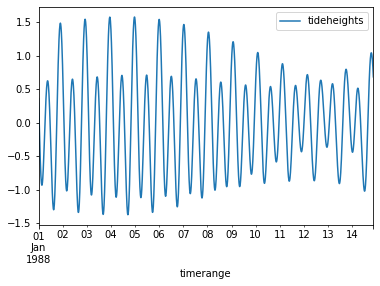

In [21]:
modelledtides[0:2000].plot(x='timerange', y='tideheights', kind='line')


In [22]:
modelledtides.reset_index(inplace=True)

In [23]:
## Goal: Try and determine average exposure time per tideheight from modelledtides.

## Find all unique tide heights in modelled tide data
unique_modelled_tideheights = modelledtides.tideheights.unique()

## Find all values for a single tide height in the unique modelled tidehieights list
# unique_modelled_tideheights[523]

## Dataframe showing unique_modelled_tideheight[x]
test = modelledtides.loc[modelledtides['tideheights'] == unique_modelled_tideheights[10]]
test.reset_index(inplace=True)
# test_orig = modelledtides.loc[modelledtides['tideheights'] == unique_modelled_tideheights[20]]

In [24]:
# plt.plot((unique_modelled_tideheights[0:100]))
# unique_modelled_tideheights[20]
len(unique_modelled_tideheights)

4345

In [25]:
## Trying to fit a polynomial regression line to the modelled tideheights
z=np.polyfit(modelledtides[0:12000].mins_from_zero, modelledtides[0:12000].tideheights,5)

In [27]:
z

array([ 1.55087669e-20, -5.12611872e-16,  6.24782779e-12, -3.40794490e-08,
        7.91448390e-05, -5.68071272e-02])

In [28]:
# len(z)
import otps

In [29]:
# otps.predi

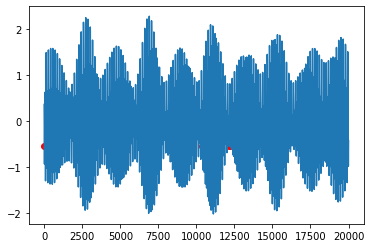

In [28]:
plt.plot(modelledtides[0:20000].mins_from_zero, modelledtides[0:20000].tideheights)
# plt.hlines(y=unique_modelled_tideheights[37], xmin=0, xmax=12000)
plt.scatter(test[0:6].mins_from_zero, test[0:6].tideheights, c='red')
# test_orig

In [ ]:
## Need to calculate flow(incoming) - ebb(outgoing) tides for exposure

    ## Test the first datetime in single tideheight dataframe back against all values to
    ## check for ebbing/flowing tide
        ## If tide is ebbing (tideheight decreasing), continue, else 
        ## drop first row from single tideheight dataframe and
        ## test again whether tide is ebbing (should be True)

## Initial datetime for tideheight x
t0 = modelledtides.loc[modelledtides.timerange == str(test.iloc[0].timerange)]

## initial datetime + 1 for tideheight x
t1 = modelledtides.loc[modelledtides.index == t0.index[0] +1]

##  Ebb or flow tide? 
## Positive value = ebbing(outgoing), Negative value = flowing (incoming)
delta_t = t0.tideheights.iloc[0] - t1.tideheights.iloc[0]
print(delta_t)

## If delta_t is a negative value, need to drop the first value from the 'test' df
## to ensure correct value pairs are subtracted to calculate median exposure
if delta_t < 0:
    print('Dropping first flow value from test df')
    test.drop([test.index[0]], inplace=True)
    t0 = modelledtides.loc[modelledtides.timerange == str(test.iloc[0].timerange)]
    t1 = modelledtides.loc[modelledtides.index == t0.index[0] +1]
    delta_t = t0.tideheights.iloc[0] - t1.tideheights.iloc[0]
    print(delta_t)
    if delta_t > 0:
        print ('Success!')
    if delta_t < 0:
        print ('Error - negative delta value returned')

In [ ]:
## Need to calculate flow(incoming) - ebb(outgoing) tides for exposure

    ## Test the first datetime in single tideheight dataframe back against all values to
    ## check for ebbing/flowing tide
        ## If tide is ebbing (tideheight decreasing), continue, else 
        ## drop first row from single tideheight dataframe and
        ## test again whether tide is ebbing (should be True)

## Initial datetime for tideheight x
t0 = modelledtides.loc[modelledtides.mins_from_zero == (test.iloc[0].mins_from_zero)]
print('t0 original', t0)
## initial datetime + 1 for tideheight x
t1 = modelledtides.loc[modelledtides.mins_from_zero == t0.mins_from_zero[0] +1]
print('t1 original', t1)
##  Ebb or flow tide? 
## Positive value = ebbing(outgoing), Negative value = flowing (incoming)
delta_t = t0.tideheights.iloc[0] - t1.tideheights.iloc[0]
print(delta_t)



## If delta_t is a negative value, need to drop the first value from the 'test' df
## to ensure correct value pairs are subtracted to calculate median exposure
while delta_t < 0:
    print('Dropping first flow value from test df')
    test.drop([0], inplace=True)
    test.reset_index(inplace=True)
    t0 = modelledtides.loc[modelledtides.mins_from_zero == (test.iloc[0].mins_from_zero)]
    print('t0 new', t0)
    t1 = modelledtides.loc[modelledtides.mins_from_zero == t0.mins_from_zero[0] +1]
    print('t1 new', t1)
    delta_t = t0.tideheights.iloc[0] - t1.tideheights.iloc[0]
    print(delta_t)
    if delta_t > 0:
        print ('Success!')
    if delta_t < 0:
        print ('Error - negative delta value returned')

In [ ]:
print(test.head())
print(test_orig.head())

In [ ]:
# unique_modelled_tideheights[300:400]

In [ ]:
# plt.plot((unique_modelled_tideheights[0:450]))
# sorted(unique_modelled_tideheights)

In [ ]:
# unique_modelled_tideheights[400]
# test

In [ ]:
# test.iloc[0].mins_from_zero
# t0.tideheights.iloc[0]
# test.drop([test.index[0]], inplace=True)
# test.iloc[0]
# test.index[0]
test

In [ ]:
##If t0 - t1 value is positive, drop t0 from 'test' dataframe and reapply ebb/flow test
test.drop(t0.index[0], inplace=True)
# test.iloc[0]
# t0.index[0]

In [ ]:
## Initial datetime for tideheight x
t0 = modelledtides.loc[modelledtides.timerange == str(test.iloc[0].timerange)]

## initial datetime + 1 for tideheight x
t1 = modelledtides.loc[modelledtides.index == t0.index[0] +1]

##  Ebb or flow tide? 
## Positive value = ebbing(outgoing), Negative value = flowing (incoming)
t0.tideheights.iloc[0] - t1.tideheights.iloc[0]

In [ ]:
test.timerange

In [ ]:
test.timerange +1

In [133]:
# ds

In [139]:
ds1=ds.copy(deep=True)

In [ ]:
# ds1

In [134]:
### http://xarray.pydata.org/en/stable/groupby.html

# ds1 = ds1.groupby('x')

In [ ]:
# ds1

In [142]:
# # http://xarray.pydata.org/en/v0.17.0/groupby.html
# # stacked = da.stack(gridcell=["ny", "nx"])

# # stacked.groupby("gridcell").sum(...).unstack("gridcell")

# stacked = ds.stack(pixel=['y', 'x'])


# ## Need to mask out always land/always water to speed up the exposed pixel workflow!!


# for x in range(0,len(stacked.pixel)):
#     arr = stacked.isel(time=0, pixel=x).to_array()
#     pc = np.sum(arr.values == int)/len(arr.values)
#     stacked.isel(time=0,pixel=x).assign({'pc_time_exposed':pc})

# ## Todo: unstack, reattach NIDEM, filter ds by nidem.where(exposed percentile = e.g. 30 to 40 % of time), plot!

# New approach: timestep mapping

In [30]:
ds

<xarray.Dataset>
Dimensions:      (time: 1, x: 2501, y: 1775)
Coordinates:
  * time         (time) datetime64[ns] 2001-07-02
  * y            (y) float64 -2.73e+06 -2.73e+06 ... -2.774e+06 -2.774e+06
  * x            (x) float64 1.941e+06 1.941e+06 ... 2.003e+06 2.004e+06
    spatial_ref  int32 3577
Data variables:
    nidem        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [31]:
modelledtides.reset_index(inplace=True)

In [32]:
modelledtides.iloc[10]

level_0                            10
index             1988-01-01 01:40:00
timerange         1988-01-01 01:40:00
tideheights                    -0.552
mins_from_zero                     10
Name: 10, dtype: object

In [46]:
# ## Working code!! When time-mapping complete, upscale this cell
# for timestep in modelledtides[-60005:-60000].index:
#     print(modelledtides['tideheights'][timestep], timestep)
#     ## For each modelled time, calculate wet vs dry pixels in aoi usingmodelled tideheight against NIDEM
#     exp = (ds.where(ds.nidem >= modelledtides['tideheights'][timestep])).nidem
#     ds[str(modelledtides['timerange'][timestep])] = exp

0.07 1570508
-0.022 1570509
-0.113 1570510
-0.203 1570511
-0.291 1570512


In [119]:
# ## TODO: Drop NIDEM variable to begin with, loop through coords, then reattach NIDEM afterwards

# ## Extract values for pixel y, x
# test = ds.isel(time=0, y=0, x=0)
# ## send modelled timestep values to array
# test = test.to_array()
# ## calculate percentage of dry (non-nan) pixels for each timestep
# pc = np.sum(test.values == int)/ len(test.values)
# ## assign percentage of time exposed to ds for coordinate
# ds.isel(time=0,y=0,x=0).assign({'pc_time_exposed': pc})

0.0

In [127]:
## Drop NIDEM for exposure calculation

# a=0
for a in ds:
    print(ds.isel(time=0, y=int(a)))
#     a=a+1
#         print ('yes')
#     for b in ds.isel(time=0, y=a):
#         print(ds.isel(time=0, y=a, x=b))
## Reattach NIDEM after exposure calculation
# ds['nidem'] = nidem

ValueError: invalid literal for int() with base 10: '2017-11-10 07:20:00'

In [118]:
# stacked.isel(time=0, z=0) == ds.isel(time=0, y=0, x=0)
# ds

<xarray.Dataset>
Dimensions:              ()
Coordinates:
    time                 datetime64[ns] 2001-07-02
    y                    float64 -2.73e+06
    x                    float64 1.941e+06
    spatial_ref          int32 3577
    z                    object ('nidem', 1941012.5, -2729737.5)
Data variables:
    nidem                bool False
    2017-11-10 07:20:00  bool False
    2017-11-10 07:30:00  bool False
    2017-11-10 07:40:00  bool False
    2017-11-10 07:50:00  bool False
    2017-11-10 08:00:00  bool False

In [101]:
test.values == int
# len(test.values)
# np.sum(test.values >= 0)

array([False, False, False, False, False, False])

In [96]:
pc

0.0

In [47]:
# ds.var()
ds
# coords=[]
# for var in ds:
#     for x in ds[vvariables:
#         for y in ds[var][0,x,]:
#             coords.append([0,x,y])

<xarray.Dataset>
Dimensions:              (time: 1, x: 2501, y: 1775)
Coordinates:
  * time                 (time) datetime64[ns] 2001-07-02
  * y                    (y) float64 -2.73e+06 -2.73e+06 ... -2.774e+06
  * x                    (x) float64 1.941e+06 1.941e+06 ... 2.003e+06 2.004e+06
    spatial_ref          int32 3577
Data variables:
    nidem                (time, y, x) float32 nan nan nan nan ... nan nan nan
    2017-11-10 07:20:00  (time, y, x) float32 nan nan nan nan ... nan nan nan
    2017-11-10 07:30:00  (time, y, x) float32 nan nan nan nan ... nan nan nan
    2017-11-10 07:40:00  (time, y, x) float32 nan nan nan nan ... nan nan nan
    2017-11-10 07:50:00  (time, y, x) float32 nan nan nan nan ... nan nan nan
    2017-11-10 08:00:00  (time, y, x) float32 nan nan nan nan ... nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [ ]:
## For Tuesday:
# Work out how to make the bit-mask from the added timestep variables in ds.

In [ ]:
blah = ds.where(ds.vars

In [ ]:
ds['blah']

In [51]:
ds.var

<bound method ImplementsDatasetReduce._reduce_method.<locals>.wrapped_func of <xarray.Dataset>
Dimensions:              (time: 1, x: 2501, y: 1775)
Coordinates:
  * time                 (time) datetime64[ns] 2001-07-02
  * y                    (y) float64 -2.73e+06 -2.73e+06 ... -2.774e+06
  * x                    (x) float64 1.941e+06 1.941e+06 ... 2.003e+06 2.004e+06
    spatial_ref          int32 3577
Data variables:
    nidem                (time, y, x) float32 nan nan nan nan ... nan nan nan
    2017-11-10 07:20:00  (time, y, x) float32 nan nan nan nan ... nan nan nan
    2017-11-10 07:30:00  (time, y, x) float32 nan nan nan nan ... nan nan nan
    2017-11-10 07:40:00  (time, y, x) float32 nan nan nan nan ... nan nan nan
    2017-11-10 07:50:00  (time, y, x) float32 nan nan nan nan ... nan nan nan
    2017-11-10 08:00:00  (time, y, x) float32 nan nan nan nan ... nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref>